<a href="https://colab.research.google.com/github/hifsakazmi/computer-vision-in-python/blob/main/Butterfly_Image_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Butterfly and Moth Image Classification Through Transfer Learning

## Project Description

* For this project, I am going to load Butterfly and Moths dataset ([Dataset Link](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species/)) from Kaggle.
* The scope is this project is image classification of top 10 classes with highest number of images.
* For image classification, first I am going to use pre-trained **MobileNetV2** from Keras. Next, I will fine-tune that model and compare performance of pre-trained and fine-tuned models.

## Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

## Downloading Dataset from Kagglehub

In [2]:
import kagglehub

# Download latest version of butterflies and moths dataset
path = kagglehub.dataset_download("gpiosenka/butterfly-images40-species")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/butterfly-images40-species/versions/13


## Exploratory Data Anaylsis

In [53]:
import os

os.listdir(path)

['valid',
 'EfficientNetB0-100-(224 X 224)- 97.59.h5',
 'training.csv.csv',
 'train',
 'test',
 'butterflies and moths.csv']

* The dataset has **train**, **test** and **valid** directories with train, test and validation image datasets, respectively.
* There is also **butterflies and moths.csv** file. I am going to use pandas dataframe to further explore this file.

In [4]:
import pandas as pd

df = pd.read_csv(path + '/butterflies and moths.csv')
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


### Count Train, Test and Validation Data

In [5]:
df.groupby('data set').count()

,class id,filepaths,labels
data set,,,
test,500,500,500
train,12594,12594,12594
valid,500,500,500


In [6]:
def count_images(dir_path):
    count = 0
    for root, dirs , files in os.walk(dir_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

In [7]:
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')
valid_dir = os.path.join(path, 'valid')

print(f"There are {count_images(train_dir)} images in train directory.")
print(f"There are {count_images(test_dir)} images in test directory.")
print(f"There are {count_images(valid_dir)} images in valid directory.")

There are 12594 images in train directory.
There are 500 images in test directory.
There are 500 images in valid directory.


### Find Unique Butterfly and Moth Classes

In [8]:
nspecies = df[df['data set'] == 'train'].labels.nunique()
print(f"There are {nspecies} species of butterflies and moths in this dataset.")

There are 100 species of butterflies and moths in this dataset.


In [9]:
df.labels.describe()

,labels
count,13594
unique,100
top,MOURNING CLOAK
freq,197


In [10]:
df.labels.value_counts()

,count
labels,
MOURNING CLOAK,197
GREEN HAIRSTREAK,186
BROWN ARGUS,179
BROOKES BIRDWING,175
SLEEPY ORANGE,162
...,...
ZEBRA LONG WING,114
CRIMSON PATCH,113
MALACHITE,113


**Findings:**
* There are 100 classes of butterflies and moths in this dataset.
* **MOURNING CLOAK** has the highest number (197) of images.
* **SIXSPOT BURNET MOTH** has the lowest number (110) of images.

In [11]:
#for dirpath, dirnames, filenames in os.walk(path):
#  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Find Top 10 Species in Dataset

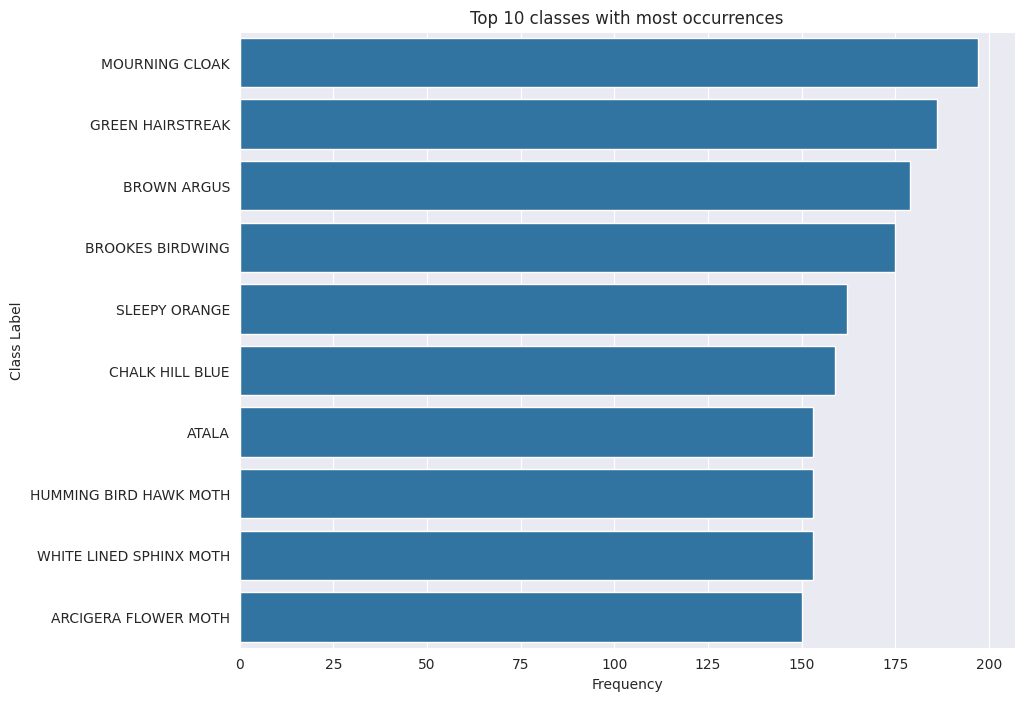

In [12]:
class_freq = {}
class_labels = df.labels
for label in class_labels:
    if label in class_freq:
        class_freq[label] +=1
    else:
        class_freq[label] = 1

# sort the classes by frequency in descending order
sorted_class = sorted(class_freq.items(),key=lambda x: x[1],reverse=True)
# print(sorted_class)
top_classes = dict(sorted_class[:10])
other_classes = dict(sorted_class[10:])

plt.figure(figsize=(10,8))
sns.countplot(y=class_labels, order=top_classes.keys())
plt.xlabel("Frequency")
plt.ylabel("Class Label")
plt.title("Top 10 classes with most occurrences")
plt.show();

### Remove Data to Only Include Top 10 Classes



For the scope of this project, I am only going to classify top 10 most occuring classes in the dataset. Therefore, following steps will remove images belonging to classes **NOT in Top 10**.

In [13]:
# Reduce the size of dataset to only include Top 10 classes
top_df = df[df['labels'].isin(top_classes)]

top_df.labels.value_counts()

,count
labels,
MOURNING CLOAK,197
GREEN HAIRSTREAK,186
BROWN ARGUS,179
BROOKES BIRDWING,175
SLEEPY ORANGE,162
CHALK HILL BLUE,159
ATALA,153
HUMMING BIRD HAWK MOTH,153
WHITE LINED SPHINX MOTH,153


In [14]:
import shutil

# Creating a function to remove directories that don't have a top 10 species
def remove_dirs(dir_path, other_classes):
    for specie in other_classes:
      specie_path = os.path.join(dir_path, specie)
      try:
        shutil.rmtree(specie_path)
      except Exception as ex:
        #print('Folder not deleted: ', specie_path)
        #print(ex)
        pass

In [15]:
# Removing directories from train, test, valid data
remove_dirs(train_dir, other_classes)
remove_dirs(test_dir, other_classes)
remove_dirs(valid_dir, other_classes)

In [16]:
print(f"There are {count_images(train_dir)} images in train directory.")
print(f"There are {count_images(test_dir)} images in test directory.")
print(f"There are {count_images(valid_dir)} images in valid directory.")

There are 1567 images in train directory.
There are 50 images in test directory.
There are 50 images in valid directory.


## Creating Train, Test and Validation Sets

In [17]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1567 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [18]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [8 2 3 4 1 5 9 8 6 2 8 7 2 2 2 8 5 7 7 6 6 5 0 2 8 2 8 2 3 6 2 6]


In [19]:
class_names = train_dataset.class_names
print(class_names)

['ARCIGERA FLOWER MOTH', 'ATALA', 'BROOKES BIRDWING', 'BROWN ARGUS', 'CHALK HILL BLUE', 'GREEN HAIRSTREAK', 'HUMMING BIRD HAWK MOTH', 'MOURNING CLOAK', 'SLEEPY ORANGE', 'WHITE LINED SPHINX MOTH']


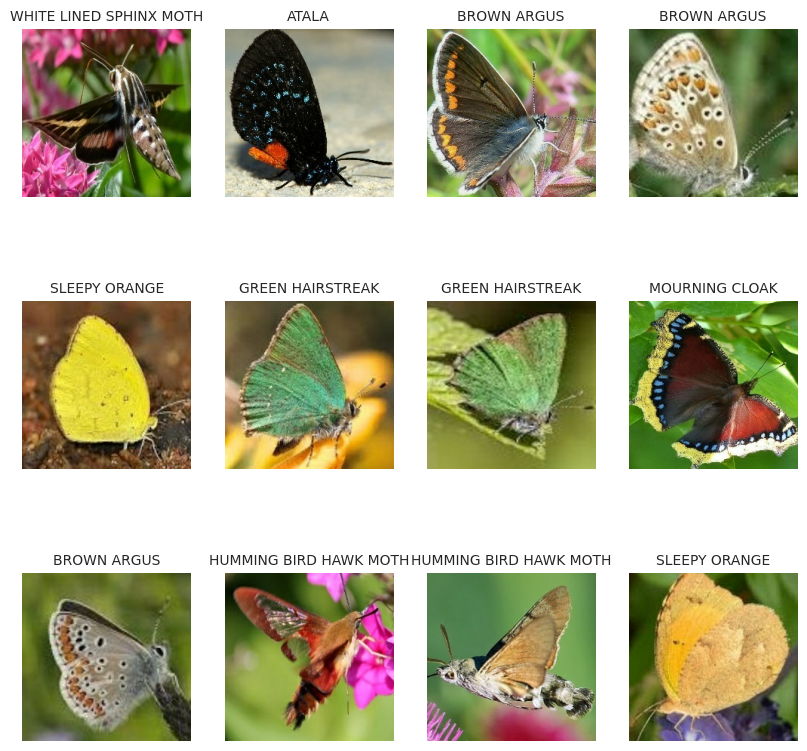

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], fontsize=10)
    plt.axis("off")

## Loading MobileNetV2 Model

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Adding Custom Top to Pre-trained MobileNetV2

In [26]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [28]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [29]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [30]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [31]:
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
len(model.trainable_variables)

2

## Train the Model

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [35]:
EPOCHS = 10

In [36]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.0976 - loss: 2.5528 - val_accuracy: 0.2000 - val_loss: 2.0478
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2780 - loss: 2.0242 - val_accuracy: 0.5200 - val_loss: 1.6097
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4877 - loss: 1.5716 - val_accuracy: 0.6600 - val_loss: 1.2879
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6028 - loss: 1.3112 - val_accuracy: 0.8400 - val_loss: 1.0418
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7237 - loss: 1.0772 - val_accuracy: 0.8600 - val_loss: 0.8588
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7824 - loss: 0.8882 - val_accuracy: 0.9200 - val_loss: 0.7198
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8368 - loss: 0.7675 - val_accuracy: 0.9200 - val_loss: 0.6108
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8801 - loss: 0.6673 - val_accuracy: 0.9400 -

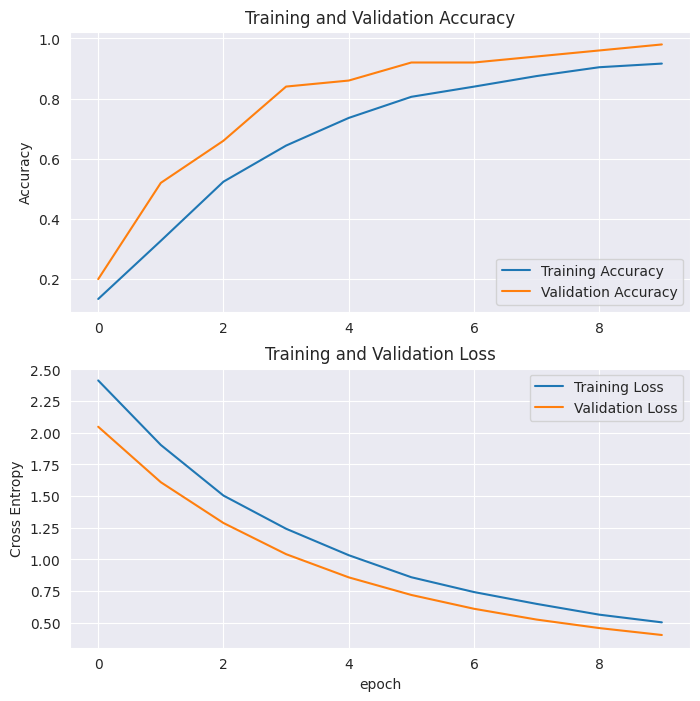

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluate the Model

In [38]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9392 - loss: 0.5350
Test accuracy : 0.9399999976158142


## Fine-Tuning the Model

In [39]:
# Printing the number of layers are in our base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [50]:
# In order to train layers in the model, trainable parameter must be set to True
base_model.trainable = True

In [41]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [42]:
len(model.trainable_variables)

32

In [43]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=["accuracy"])

In [44]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,538,890 (5.87 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [45]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - accuracy: 0.7750 - loss: 0.7188 - val_accuracy: 0.7400 - val_loss: 0.4545
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9913 - loss: 0.0489 - val_accuracy: 0.9000 - val_loss: 0.2357
Epoch 13/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9958 - loss: 0.0238 - val_accuracy: 0.9800 - val_loss: 0.1492
Epoch 14/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9800 - val_loss: 0.1047
Epoch 15/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9800 - val_loss: 0.0916
Epoch 16/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9800 - val_loss: 0.0692
Epoch 17/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9800 - val_loss: 0.0556
Epoch 18/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

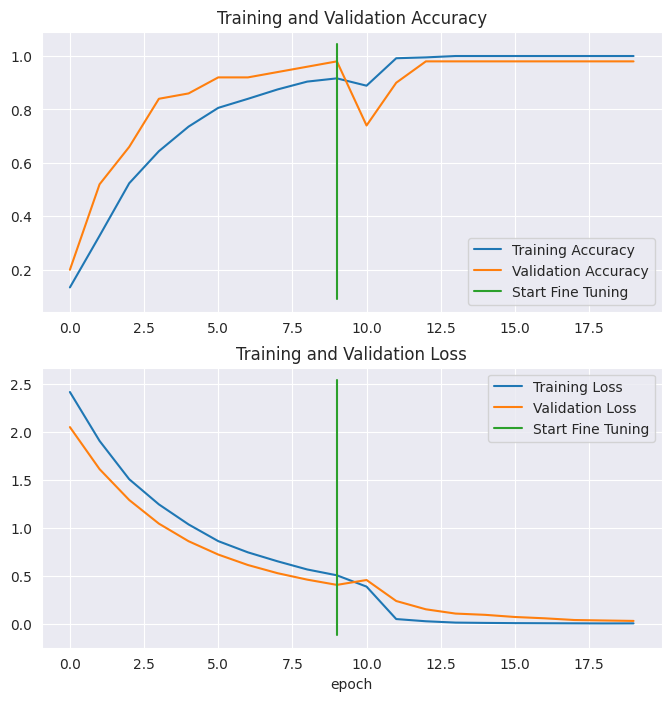

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9154 - loss: 0.1868
Test accuracy : 0.9200000166893005


Predictions:
 [0 0 2 9 4 3 0 5 5 9 2 5 7 3 3 6 8 1 1 6 6 8 7 2 3 7 4 8 4 8 0 7]
Labels:
 [6 0 2 9 4 3 0 5 5 9 2 5 7 3 1 6 8 1 2 6 6 8 7 2 3 7 4 8 4 8 0 7]


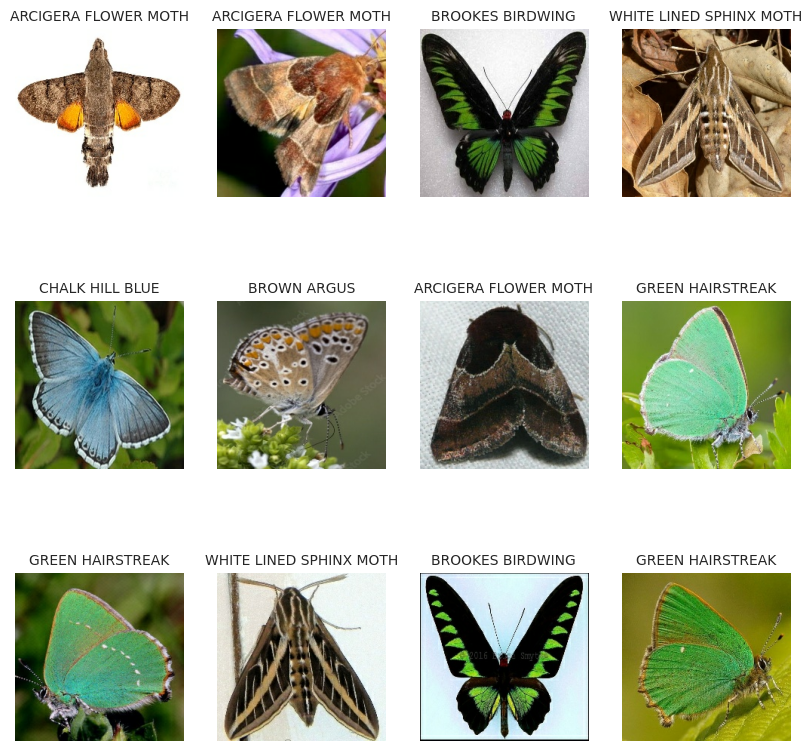

In [52]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_classes[i]], fontsize=10)
  plt.axis("off")